# Import relevant libraries

In [69]:
import os
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [70]:
# disable false positive warnings
pd.options.mode.chained_assignment = None

# Setup path

In [71]:
# set up paths
base_path = os.path.join('..', 'datasets')
cleaned_data_path = os.path.join(base_path, 'cleaned_data')

# Load data

In [72]:
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))
rating_df = pd.read_csv(os.path.join(cleaned_data_path, 'player_rating.csv'))

# Data preparation

In [73]:
rating_eval_df = pd.merge(perf_eval_df, rating_df, on = ['player_name', 'year'], how = 'inner')
rating_eval_df

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,overall_rating
0,PSV Eindhoven,Danny Koevermans,28.0,AZ Alkmaar,in,6.21,2007,70.00
1,AZ Alkmaar,Danny Koevermans,28.0,PSV Eindhoven,out,6.21,2007,70.00
2,PSV Eindhoven,Danko Lazovic,24.0,Vitesse,in,5.40,2007,75.50
3,Vitesse Arnhem,Danko Lazovic,24.0,PSV Eindhoven,out,5.40,2007,75.50
4,PSV Eindhoven,Tom van der Leegte,30.0,VfL Wolfsburg,in,0.45,2007,68.00
...,...,...,...,...,...,...,...,...
7347,SD Eibar,Keko,24.0,Málaga CF,out,4.50,2016,72.75
7348,Málaga CF,Keko,24.0,SD Eibar,in,4.50,2016,72.75
7349,Deportivo de La Coruña,Florin Andone,23.0,Córdoba CF,in,5.13,2016,72.00
7350,Deportivo de La Coruña,Przemyslaw Tyton,29.0,VfB Stuttgart,in,0.45,2016,76.00


# Analysis

**Thesis Statement:**

Workflow:
1) Step1  
2) Step2  
3) Step3  

**To do**
- There seems to be a trend on age-price so we dev scaling factor (average price by age with base age) to diminish the effect of age on price.
- Identify the effect of homophily (Membership closure) on performance -> performance metric = f(price, scaling_factor) and maybe with combination of other metrics
- Identify the behavior of the transfer if it's related to our analysis,   
  - if yes: the analysis might be the cause  
  - if no: give some recommendation

## Rating-Age Analysis

In [74]:
rating_age = rating_eval_df[['age', 'overall_rating']]
rating_age

,age,overall_rating
0,28.0,70.00
1,28.0,70.00
2,24.0,75.50
3,24.0,75.50
4,30.0,68.00
...,...,...
7347,24.0,72.75
7348,24.0,72.75
7349,23.0,72.00
7350,29.0,76.00


<AxesSubplot:xlabel='age', ylabel='overall_rating'>

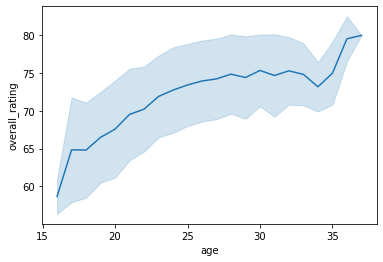

In [75]:
# the variance is quite high
sns.lineplot(data = rating_age, x = 'age', y = 'overall_rating', estimator= np.mean, ci = 'sd')

<AxesSubplot:xlabel='overall_rating', ylabel='Count'>

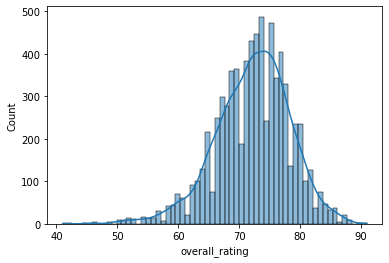

In [76]:
# unlike fee, the distribution for rating is slighty close to Gaussian distribution
sns.histplot(rating_age['overall_rating'], kde = True)

In [77]:
# descriptive statistics
desc_stat = rating_age.groupby('age')['overall_rating'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
# remove group with small number of observations
desc_stat = desc_stat[desc_stat['count'] > 30]

In [78]:
# since data is roughly normally distributed, the mean and median is relatively equal.
# in this case we use median to make it consistent with the fee-age analysis
desc_stat

,mean,median,std,min,max,count
age,,,,,,
18.0,64.810904,65.000000,6.303559,46.0,77.333333,118
19.0,66.498046,67.000000,6.016893,46.0,80.000000,255
20.0,67.586871,67.900000,6.421717,42.0,85.500000,420
21.0,69.535753,69.750000,6.062078,46.0,86.000000,568
22.0,70.232928,70.500000,5.621225,45.0,85.000000,687
23.0,71.910610,72.000000,5.404317,51.0,87.000000,795
24.0,72.751005,73.000000,5.659094,49.0,89.500000,842
25.0,73.434356,74.000000,5.432464,50.0,87.500000,747
26.0,73.961165,74.000000,5.362270,49.0,87.000000,690


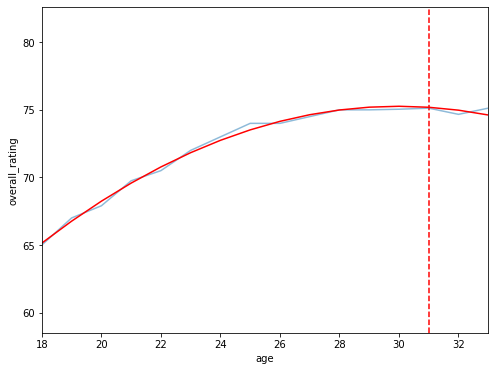

In [79]:
# visualize
fig, ax = plt.subplots(figsize = (8, 6))

sns.lineplot(data = rating_age, x = 'age', y = 'overall_rating', estimator= np.median, ci = None, alpha = 0.5)

xlim = (desc_stat.index[0], desc_stat.index[-1])
ylim = (min(desc_stat['median']*0.9), max(desc_stat['median'])*1.1)

# fit polynomial to smoothen the trend (for adjustment coefficient)
x = list(desc_stat['median'].index)
y = list(desc_stat['median'])

# smoothen the liner
fit = np.polyfit(x, y, deg = 2)
poly1d = np.poly1d(fit)

# add adjustment line
plt.plot(x, poly1d(x), '-', c = 'red')

# get the turning point (slope < 0)
idx = [idx for idx,val in enumerate(np.diff(poly1d(x))) if val < 0][0 + 1]

# add vertical line at the turning point
plt.vlines(x = x[idx], ymin = ylim[0], ymax = ylim[1],
           colors = 'red', linestyles = 'dashed')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [80]:
# develop adjustment coefficient
fitted_value = poly1d(x)

baseline = fitted_value[0]
base_value = np.divide(fitted_value, baseline)
coef = np.reciprocal(base_value)

temp_df = pd.DataFrame(data = {'age': desc_stat['median'].index, 
                               'coef': coef})
temp_df

,age,coef
0,18.0,1.000000
1,19.0,0.975733
2,20.0,0.954586
3,21.0,0.936233
4,22.0,0.920404
5,23.0,0.906881
6,24.0,0.895483
7,25.0,0.886067
8,26.0,0.878516
9,27.0,0.872741


In [81]:
# extend age range to cover the data using lower-upper bound coefficient
age_df = pd.DataFrame(data = {'age': sorted(rating_age['age'].unique())})
adj_coef_table = pd.merge(age_df, temp_df, on = 'age', how = 'left')
adj_coef_table['coef'] = adj_coef_table['coef'].interpolate(method = 'linear', limit_direction = 'both')
adj_coef_table

,age,coef
0,16.0,1.000000
1,17.0,1.000000
2,18.0,1.000000
3,19.0,0.975733
4,20.0,0.954586
5,21.0,0.936233
6,22.0,0.920404
7,23.0,0.906881
8,24.0,0.895483
9,25.0,0.886067


## Homophily-Performance Analysis

In [82]:
node_edge_df.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year
0,Fortuna Sittard,René Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,0.0,1992


### Create structured data

In [83]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(node_edge_df['year'].unique()))
club_list = sorted(node_edge_df['club_involved_name'].unique())

In [84]:
# define function to remove elements in a list from another list
def remove_elem_by_list(list1, list2):
    for elem in list2:
        try:
            list1.remove(elem)
        except Exception:
            pass
    return list1

In [85]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):
    
    if prev_year in nested_dict.keys():
        
        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])
    
    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}
    
    # subset data by year
    data = node_edge_df[node_edge_df['year'] == year]
    
    # subset for transfer_movement == 'in', 'out'
    data_in = data[data['transfer_movement'] == 'in']
    data_out = data[data['transfer_movement'] == 'out']
        
    # loop over club:
    for club in club_list:
        
        # subset data by club
        temp_data_in = data_in[data_in['club_name'] == club]
        temp_data_out = data_out[data_out['club_name'] == club]
        
        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])
        
        if prev_year in nested_dict.keys():
            
            # catch bug
            if club_member[club] is None:
                club_member[club] = []
            
            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)
            
        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in, player_list_out)
            
    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member
    
    # set previous year
    prev_year = year

### Performance Analysis

In [86]:
rating_eval_df.head()

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,overall_rating
0,PSV Eindhoven,Danny Koevermans,28.0,AZ Alkmaar,in,6.21,2007,70.0
1,AZ Alkmaar,Danny Koevermans,28.0,PSV Eindhoven,out,6.21,2007,70.0
2,PSV Eindhoven,Danko Lazovic,24.0,Vitesse,in,5.40,2007,75.5
3,Vitesse Arnhem,Danko Lazovic,24.0,PSV Eindhoven,out,5.40,2007,75.5
4,PSV Eindhoven,Tom van der Leegte,30.0,VfL Wolfsburg,in,0.45,2007,68.0


In [87]:
adj_coef_table.head()

,age,coef
0,16.0,1.000000
1,17.0,1.000000
2,18.0,1.000000
3,19.0,0.975733
4,20.0,0.954586


In [88]:
# add `adjusted_fee` column which adjusted for player's age
rating_eval_df = pd.merge(rating_eval_df, adj_coef_table, on = 'age', how = 'left')
rating_eval_df['adjusted_rating'] = np.multiply(rating_eval_df['overall_rating'], rating_eval_df['coef'])

# remove `coef` column
rating_eval_df.drop(columns = 'coef', inplace = True)
rating_eval_df

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,overall_rating,adjusted_rating
0,PSV Eindhoven,Danny Koevermans,28.0,AZ Alkmaar,in,6.21,2007,70.00,60.807093
1,AZ Alkmaar,Danny Koevermans,28.0,PSV Eindhoven,out,6.21,2007,70.00,60.807093
2,PSV Eindhoven,Danko Lazovic,24.0,Vitesse,in,5.40,2007,75.50,67.608984
3,Vitesse Arnhem,Danko Lazovic,24.0,PSV Eindhoven,out,5.40,2007,75.50,67.608984
4,PSV Eindhoven,Tom van der Leegte,30.0,VfL Wolfsburg,in,0.45,2007,68.00,58.853506
...,...,...,...,...,...,...,...,...,...
7347,SD Eibar,Keko,24.0,Málaga CF,out,4.50,2016,72.75,65.146405
7348,Málaga CF,Keko,24.0,SD Eibar,in,4.50,2016,72.75,65.146405
7349,Deportivo de La Coruña,Florin Andone,23.0,Córdoba CF,in,5.13,2016,72.00,65.295406
7350,Deportivo de La Coruña,Przemyslaw Tyton,29.0,VfB Stuttgart,in,0.45,2016,76.00,65.836209


In [89]:
# subset only `transfer_movement` == 'in' to avoid double counting
df = rating_eval_df[rating_eval_df['transfer_movement'] == 'in']
df.reset_index(drop = True, inplace = True)
# clean the table
df.drop_duplicates(inplace = True)

In [90]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
df.drop(columns = 'count', inplace = True)
df

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,overall_rating,adjusted_rating,num_transfer,max_transfer
0,PSV Eindhoven,Danny Koevermans,28.0,AZ Alkmaar,in,6.210,2007,70.00,60.807093,1,1
1,PSV Eindhoven,Danko Lazovic,24.0,Vitesse,in,5.400,2007,75.50,67.608984,1,2
2,PSV Eindhoven,Tom van der Leegte,30.0,VfL Wolfsburg,in,0.450,2007,68.00,58.853506,1,1
3,PSV Eindhoven,Mike Zonneveld,26.0,NAC Breda,in,0.405,2007,68.50,60.178360,1,1
4,Ajax Amsterdam,Dennis Rommedahl,28.0,Charlton,in,0.918,2007,71.00,61.675765,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4162,RCD Espanyol Barcelona,Javi Fuego,32.0,Valencia,in,0.900,2016,80.00,69.506466,3,3
4163,Málaga CF,Keko,24.0,SD Eibar,in,4.500,2016,72.75,65.146405,1,1
4164,Deportivo de La Coruña,Florin Andone,23.0,Córdoba CF,in,5.130,2016,72.00,65.295406,1,1
4165,Deportivo de La Coruña,Przemyslaw Tyton,29.0,VfB Stuttgart,in,0.450,2016,76.00,65.836209,3,3


In [91]:
# only select the players that have at least two transfers to see the improvement
target_player = list(df[df['num_transfer'] > 1]['player_name'])

df = df[df['player_name'].isin(target_player)]
df.reset_index(drop = True, inplace = True)
df

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,overall_rating,adjusted_rating,num_transfer,max_transfer
0,PSV Eindhoven,Danko Lazovic,24.0,Vitesse,in,5.40,2007,75.5,67.608984,1,2
1,Real Madrid,Wesley Sneijder,23.0,Ajax,in,24.30,2007,83.0,75.271093,1,2
2,Liverpool FC,Ryan Babel,20.0,Ajax,in,15.53,2007,77.0,73.503159,1,2
3,AZ Alkmaar,Mounir El Hamdaoui,23.0,Willem II,in,6.30,2007,74.0,67.109167,1,3
4,AZ Alkmaar,Ari,21.0,Kalmar FF,in,4.50,2007,71.0,66.472541,1,3
...,...,...,...,...,...,...,...,...,...,...,...
2393,RCD Espanyol Barcelona,Roberto,30.0,Olympiacos,in,2.70,2016,80.0,69.239418,15,16
2394,RCD Espanyol Barcelona,Roberto,30.0,Olympiacos,in,2.70,2016,70.0,60.584491,16,16
2395,RCD Espanyol Barcelona,Javi Fuego,32.0,Valencia,in,0.90,2016,80.0,69.506466,3,3
2396,Deportivo de La Coruña,Przemyslaw Tyton,29.0,VfB Stuttgart,in,0.45,2016,76.0,65.836209,3,3


In [92]:
# get player_list
player_list = list(df['player_name'].unique())

In [93]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):
    
    # subset df by player
    temp_df = df[df['player_name'] == player]
    
    # reset_index
    temp_df.reset_index(drop = True, inplace = True)
    
    # initiate inside dictionaries
    aff_clubs = {}
    
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """
    
    for row in range(len(temp_df) - 1):
        
        # initiate inside dictionaries
        year_member = {}
        
        club_involved_name = temp_df.iloc[row]['club_involved_name']
        
        year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])
        
        # get the affiliated player each year from `nested_dict`
        for year in year_list:
            
            aff_players = nested_dict[year][club_involved_name]
            
            # add data to `year_member`
            year_member[year] = aff_players
      
        # add data to aff_club 
        
        # adjust for the case when player moves back to the club he's been before
        if club_involved_name in aff_clubs.keys():
            
                aff_clubs[club_involved_name].update(year_member)
            
        else:
            
            aff_clubs[club_involved_name] = year_member
            
    # add data to was_in
    was_in[player] = aff_clubs

In [94]:
was_in

{'Danko Lazovic': {'Vitesse': {2007: [], 2008: []}},
 'Wesley Sneijder': {'Ajax': {2007: [], 2008: []}},
 'Ryan Babel': {'Ajax': {2007: [], 2008: [], 2009: []}},
 'Mounir El Hamdaoui': {'Willem II': {2007: [], 2008: [], 2009: []},
  'AZ Alkmaar': {2010: ['Ruud Heus',
    'Hendrie Krüzen',
    'Krzystof Bociek',
    'Niels Gerestein',
    'Donny Huysen',
    'Ariel Rosada',
    'Abdelkrim El Hadrioui',
    'Stijn Schaars',
    'Joey Didulica',
    'Maarten Martens',
    'Graziano Pellè',
    'Sergio Romero',
    'Héctor Moreno',
    'Simon Poulsen',
    'Brett Holman',
    'Nick van der Velden',
    'Niklas Moisander',
    'Rasmus Elm',
    'Pontus Wernbloom',
    'Ragnar Klavan',
    'Erik Heijblok',
    'Celso Ortiz',
    'Nick Viergever',
    'Charlison Benschop',
    'Erik Falkenburg',
    'Esteban Alvarado',
    'Dirk Marcellis',
    'Hobie Verhulst',
    'Kolbeinn Sigthórsson',
    'Giliano Wijnaldum',
    'Erik Schouten',
    'Ali Messaoud',
    'Ramón',
    'Jóhann Berg Gudmunds

In [95]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace = True)
df.reset_index(drop = True, inplace = True)
df

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,overall_rating,adjusted_rating,num_transfer,max_transfer
0,Ipswich Town,Aaron Cresswell,21.0,Tranmere Rovers,in,0.248,2011,64.000000,59.918910,1,2
1,West Ham United,Aaron Cresswell,24.0,Ipswich,in,4.280,2014,70.333333,62.982321,2,2
2,Genoa CFC,Abdelkader Ghezzal,23.0,FC Crotone,in,2.700,2007,63.000000,57.133480,1,2
3,AC Siena,Abdelkader Ghezzal,23.0,Genoa,in,1.350,2008,63.000000,57.133480,2,2
4,Sevilla FC,Abdoulay Konko,24.0,Genoa,in,7.650,2008,76.000000,68.056726,1,3
...,...,...,...,...,...,...,...,...,...,...,...
2393,FC Barcelona,Zlatan Ibrahimovic,27.0,Inter,in,62.550,2009,88.500000,77.237544,1,3
2394,AC Milan,Zlatan Ibrahimovic,29.0,FC Barcelona,in,21.600,2011,87.000000,75.365134,2,3
2395,Paris Saint-Germain,Zlatan Ibrahimovic,30.0,AC Milan,in,18.900,2012,88.000000,76.163360,3,3
2396,VfL Wolfsburg,Zvjezdan Misimovic,26.0,1.FC Nuremberg,in,3.600,2008,77.000000,67.645748,1,2


In [96]:
# generate `k` column

# initiate a list
k = []

# loop over the dataset
for i in tqdm(range(len(df))):
    
    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:  
        
        k.append(None)
        
    else:  
        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_involved_name'][i-1]
        club = df['club_involved_name'][i]
        prev_year = df['year'][i-1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)
        
        # get all the affiliated players
        aff_players = []
        for year in year_range:
            aff_player = was_in[player][prev_club][year]
            aff_players.extend(aff_player)
        
        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]
        
        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))
        
        # get `k_val`
        k_val = len(set.intersection(set(aff_players), set(in_club_player)))
        
        # append `k_val` to `k`
        k.append(k_val)
        
        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k

In [100]:
# change in adjusted_rating as a proxy of performance --> `perf_change
df['perf_change'] = df.groupby('player_name')['adjusted_rating'].pct_change()

In [101]:
# get `k-perf` table
k_perf = df[['k', 'perf_change']].dropna()
k_perf

,k,perf_change
1,0.0,0.051126
3,0.0,0.000000
5,0.0,-0.038310
6,0.0,0.006760
8,0.0,0.045837
...,...,...
2390,0.0,-0.009234
2392,0.0,-0.065716
2394,0.0,-0.024242
2395,0.0,0.010591


In [102]:
k_perf.sort_values(by = 'k', ascending = False)

,k,perf_change
446,56.0,-0.021606
827,26.0,-0.058516
642,21.0,0.008317
142,19.0,0.000000
261,19.0,-0.028350
...,...,...
794,0.0,0.034173
792,0.0,-0.003874
791,0.0,0.000000
790,0.0,0.066141


In [103]:
pd.DataFrame(k_perf.groupby('k')['perf_change'].agg(['median', 'count'])).reset_index()

,k,median,count
0,0.0,0.002577,1388
1,1.0,0.000317,28
2,2.0,0.012819,6
3,3.0,-0.000281,1
4,4.0,0.020465,2
5,8.0,-0.012302,1
6,11.0,0.000000,1
7,12.0,-0.018596,1
8,16.0,0.000000,1
9,19.0,0.000000,3


In [104]:
# get average perf_change by k
table = pd.DataFrame(k_perf.groupby('k')['perf_change'].agg(['mean', 'median', 'count'])).reset_index()
k = table['k']
perf_change = table['median']

In [105]:
table

,k,mean,median,count
0,0.0,0.018323,0.002577,1388
1,1.0,0.007631,0.000317,28
2,2.0,0.055246,0.012819,6
3,3.0,-0.000281,-0.000281,1
4,4.0,0.020465,0.020465,2
5,8.0,-0.012302,-0.012302,1
6,11.0,0.000000,0.000000,1
7,12.0,-0.018596,-0.018596,1
8,16.0,0.000000,0.000000,1
9,19.0,-0.009450,0.000000,3


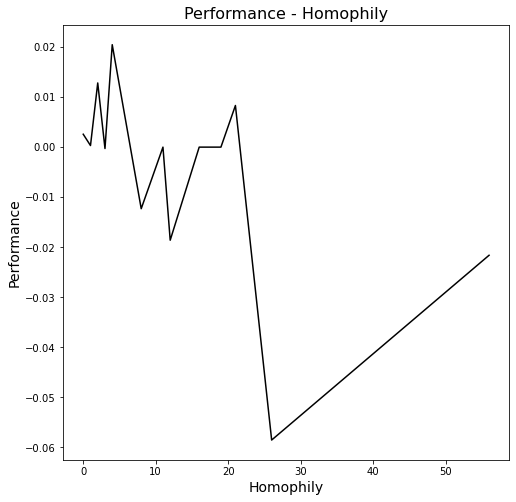

In [106]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Homophily', size = 14)
ax.set_ylabel('Performance', size = 14)
ax.set_title('Performance - Homophily', size = 16)

ax.plot(k, perf_change, color = 'black')



plt.show()